# A Sodium Fast Reactor geometry 
This notebook can be used as a template for modeling Sodium fast reactors.

SOURCES:
A. Facchini, V. Giusti, R. Ciolini, K. Tucek, D. Thomas, E. D'Agata, "Detailed Neutornics Study of the Power Evolution for the European Sodium Fast Reactor During a Positive Insertion of Reactivity," Nuc. Eng. Design  313 1-9 (2017)
A. Ponomarev, A. Bednarova, K. Mikityuk, "New Sodium Fast Reactor Neutronics Benchmark," PHYSOR 2018

In [1]:
%matplotlib inline
import openmc

In [2]:
# Materials definitions

u235 = openmc.Material(name='U235')
u235.add_nuclide('U235', 1.0)
u235.set_density('g/cm3', 10.0)

u238 = openmc.Material(name='U238')
u238.add_nuclide('U238', 1.0)
u238.set_density('g/cm3', 10.0)

pu238 = openmc.Material(name='Pu238')
pu238.add_nuclide('Pu238', 1.0)
pu238.set_density('g/cm3', 10.0)

pu239 = openmc.Material(name='U235')
pu239.add_nuclide('Pu239', 1.0)
pu239.set_density('g/cm3', 10.0)

pu240 = openmc.Material(name='Pu240')
pu240.add_nuclide('Pu240', 1.0)
pu240.set_density('g/cm3', 10.0)

pu241 = openmc.Material(name='Pu241')
pu241.add_nuclide('Pu241', 1.0)
pu241.set_density('g/cm3', 10.0)

pu242 = openmc.Material(name='Pu242')
pu242.add_nuclide('Pu242', 1.0)
pu242.set_density('g/cm3', 10.0)

am241 = openmc.Material(name='Am241')
am241.add_nuclide('Am241', 1.0)
am241.set_density('g/cm3', 10.0)

o16 = openmc.Material(name='O16')
o16.add_nuclide('O16', 1.0)
o16.set_density('g/cm3', 10.0)

sodium = openmc.Material(name='Na')
sodium.add_nuclide('Na23', 1.0)
sodium.set_density('g/cm3', 0.96)

cu63 = openmc.Material(name='Cu63')
cu63.set_density('g/cm3', 10.0)
cu63.add_nuclide('Cu63', 1.0)

Al2O3 = openmc.Material(name='Al2O3')
Al2O3.set_density('g/cm3', 10.0)
Al2O3.add_element('O', 3.0)
Al2O3.add_element('Al', 2.0)

In [3]:
# Material mixtures
inner = openmc.Material.mix_materials(
    [u235, u238, pu238, pu239, pu240, pu241, pu242, am241, o16],
    [0.0019, 0.7509, 0.0046, 0.0612, 0.0383, 0.0106, 0.0134, 0.001, 0.1181],
    'wo')
outer = openmc.Material.mix_materials(
    [u235, u238, pu238, pu239, pu240, pu241, pu242, am241, o16],
    [0.0018, 0.73, 0.0053, 0.0711, 0.0445, 0.0124, 0.0156, 0.0017, 0.1176],
    'wo')
clad = openmc.Material.mix_materials(
    [cu63,Al2O3], [0.997,0.003], 'wo')

In [4]:
# Instantiate a Materials collection and export to xml
materials_file = openmc.Materials([inner, outer, sodium, clad])
materials_file.export_to_xml()

In [42]:
# Geometry definitions

fuel_or = openmc.ZCylinder(r=0.943/2) 
clad_ir = openmc.ZCylinder(r=0.973/2) 
clad_or = openmc.ZCylinder(r=1.073/2) 

top = openmc.ZPlane(z0=+50, boundary_type='vacuum')
bottom = openmc.ZPlane(z0=-50, boundary_type='vacuum') 

fuel_region = -fuel_or & -top & +bottom
gap_region  = +fuel_or & -clad_ir  & -top & +bottom
clad_region = +clad_ir & -clad_or  & -top & +bottom
moderator_region = +clad_or & -top & +bottom
 
gap_cell = openmc.Cell(fill=inner, region=gap_region)
clad_cell = openmc.Cell(fill=clad, region=clad_region)
sodium_cell = openmc.Cell(fill=sodium, region=moderator_region)

In [43]:
inner_fuel_cell = openmc.Cell(fill=inner, region=fuel_region)
inner_u = openmc.Universe(cells=(inner_fuel_cell, gap_cell, clad_cell, sodium_cell))

In [44]:
outer_fuel_cell = openmc.Cell(fill=outer, region=fuel_region)
outer_u = openmc.Universe(cells=(outer_fuel_cell, gap_cell, clad_cell, sodium_cell))

In [45]:
# Creating filling for emtpy space in the core

sodium_mod_cell = openmc.Cell(fill=sodium)
sodium_mod_u = openmc.Universe(cells=(sodium_mod_cell,))

In [46]:
# Define a lattice for inner assemblies
in_lat = openmc.HexLattice(lattice_id=1, name='inner assembly')
in_lat.center = (0., 0.)
in_lat.pitch = (21.08/17,)
in_lat.orientation = 'x'
in_lat.outer = sodium_mod_u

# Create rings of fuel universes that will fill the lattice
inone = [inner_u]*48
intwo = [inner_u]*42
inthree = [inner_u]*36
infour = [inner_u]*30
infive = [inner_u]*24
insix = [inner_u]*18
inseven = [inner_u]*12
ineight = [inner_u]*6
innine = [inner_u]*1
in_lat.universes = [inone,intwo,inthree,infour,infive,insix,inseven,ineight,innine]

# Create the prism that will contain the lattice
outer_in_surface = -openmc.model.HexagonalPrism(edge_length=12.1705, orientation='x')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
main_in_assembly = openmc.Cell(fill=in_lat, region=outer_in_surface & -top & +bottom)

# Fill a cell with a material that will surround the lattice
out_in_assembly  = openmc.Cell(fill=sodium, region=~outer_in_surface & -top & +bottom)

# Create a universe that contains both 
main_in_u = openmc.Universe(cells=[main_in_assembly, out_in_assembly])

/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Lattice instance already exists with id=1.
  warn(msg, IDWarning)


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

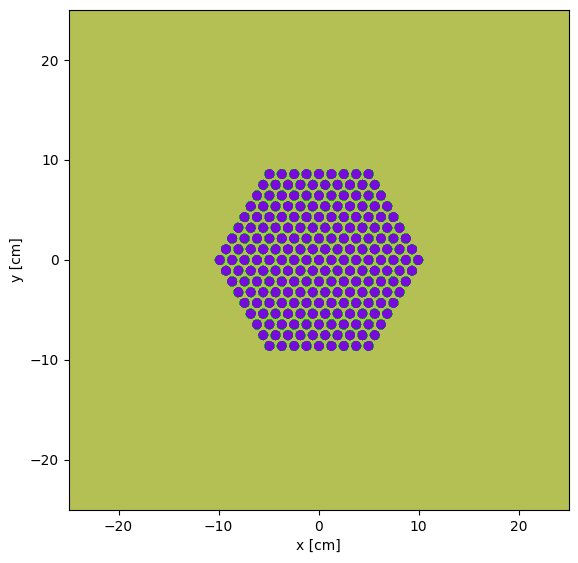

In [47]:
main_in_u.plot(origin = (0,0,0), pixels=(500, 500), width = (50.,50.), color_by = 'material')

In [48]:
# Define a lattice for outer assemblies
out_lat = openmc.HexLattice(lattice_id=2, name='outer assembly')
out_lat.center = (0., 0.)
out_lat.pitch = (21.08/17,)
out_lat.orientation = 'x'
out_lat.outer = sodium_mod_u

# Create rings of fuel universes that will fill the lattice
outone = [outer_u]*48
outtwo = [outer_u]*42
outthree = [outer_u]*36
outfour = [outer_u]*30
outfive = [outer_u]*24
outsix = [outer_u]*18
outseven = [outer_u]*12
outeight = [outer_u]*6
outnine = [outer_u]*1
out_lat.universes = [outone,outtwo,outthree,outfour,outfive,outsix,outseven,outeight,outnine]

# Create the prism that will contain the lattice
outer_out_surface = -openmc.model.HexagonalPrism(edge_length=12.1705)

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
main_out_assembly = openmc.Cell(fill=out_lat, region=outer_out_surface & -top & +bottom)

# Fill a cell with a material that will surround the lattice
out_out_assembly  = openmc.Cell(fill=sodium,  region=~outer_out_surface & -top & +bottom)

# Create a universe that contains both 
main_out_u = openmc.Universe(cells=[main_out_assembly, out_out_assembly])

/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Lattice instance already exists with id=2.
  warn(msg, IDWarning)


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

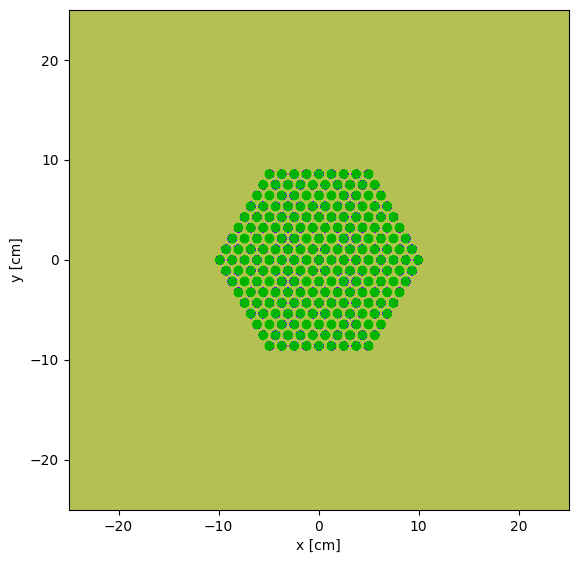

In [49]:
main_out_u.plot(origin = (0,0,0), pixels=(500, 500), width = (50.,50.), color_by = 'material')

In [51]:
# Create a hexagonal water cell

reflector_assembly = -openmc.model.HexagonalPrism(edge_length=12.1705, orientation='x')
ref_cell = openmc.Cell(fill=sodium, region=reflector_assembly & -top & +bottom)
out_ref_cell  = openmc.Cell(fill=sodium, region=~reflector_assembly & -top & +bottom)
ref_u = openmc.Universe(cells=[ref_cell, out_ref_cell])

We have 3 types of assemblies created. We can now make the entire reactor core by creating a lattice that is filled with the assemblies. 

In [52]:
# Define the core lattice

core_lat = openmc.HexLattice(lattice_id=3, name='core')
core_lat.center = (0., 0.)
core_lat.pitch = (21.08,)
core_lat.outer = sodium_mod_u

/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Lattice instance already exists with id=3.
  warn(msg, IDWarning)


In [53]:
# Create rings of fuel universes that will fill the lattice
ref_one = [ref_u] * 96
ref_two = [ref_u] * 90
ref_three = [ref_u] * 84
ref_four = ([ref_u] * 5 + [main_out_u] * 4 + [ref_u] * 4) * 6
ref_five = ([ref_u] + [main_out_u] * 11) * 6
out_one = [main_out_u]*66
out_two = [main_out_u]*60
out_three = ([main_out_u]*2 + [main_in_u]*6 + [main_out_u] * 1)*6
in_one = [main_in_u]*48
in_two = [main_in_u]*42
in_three = [main_in_u]*36
in_four = [main_in_u]*30
in_five = [main_in_u]*24
in_six = [main_in_u]*18
in_seven = [main_in_u]*12
in_eight = [main_in_u]*6
in_nine = [main_in_u]*1
core_lat.universes = [ref_one,ref_two,ref_three,ref_four,ref_five,out_one,out_two,out_three,in_one,in_two,in_three,in_four,in_five,in_six,in_seven,in_eight,in_nine]

In [54]:
# Create the prism that will contain the lattice
outer_core_surface = -openmc.model.HexagonalPrism(edge_length=347.82, boundary_type='vacuum')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
core = openmc.Cell(cell_id=13, fill=core_lat, region=outer_core_surface & -top & +bottom)

# Fill a cell with a material that will surround the lattice
out_core = openmc.Cell(cell_id=14, fill=outer, region=~outer_core_surface & -top & +bottom)

# Create a universe that contains both 
main_u = openmc.Universe(universe_id=7, cells=[core, out_core]) 

/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=13.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=14.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another UniverseBase instance already exists with id=7.
  warn(msg, IDWarning)


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

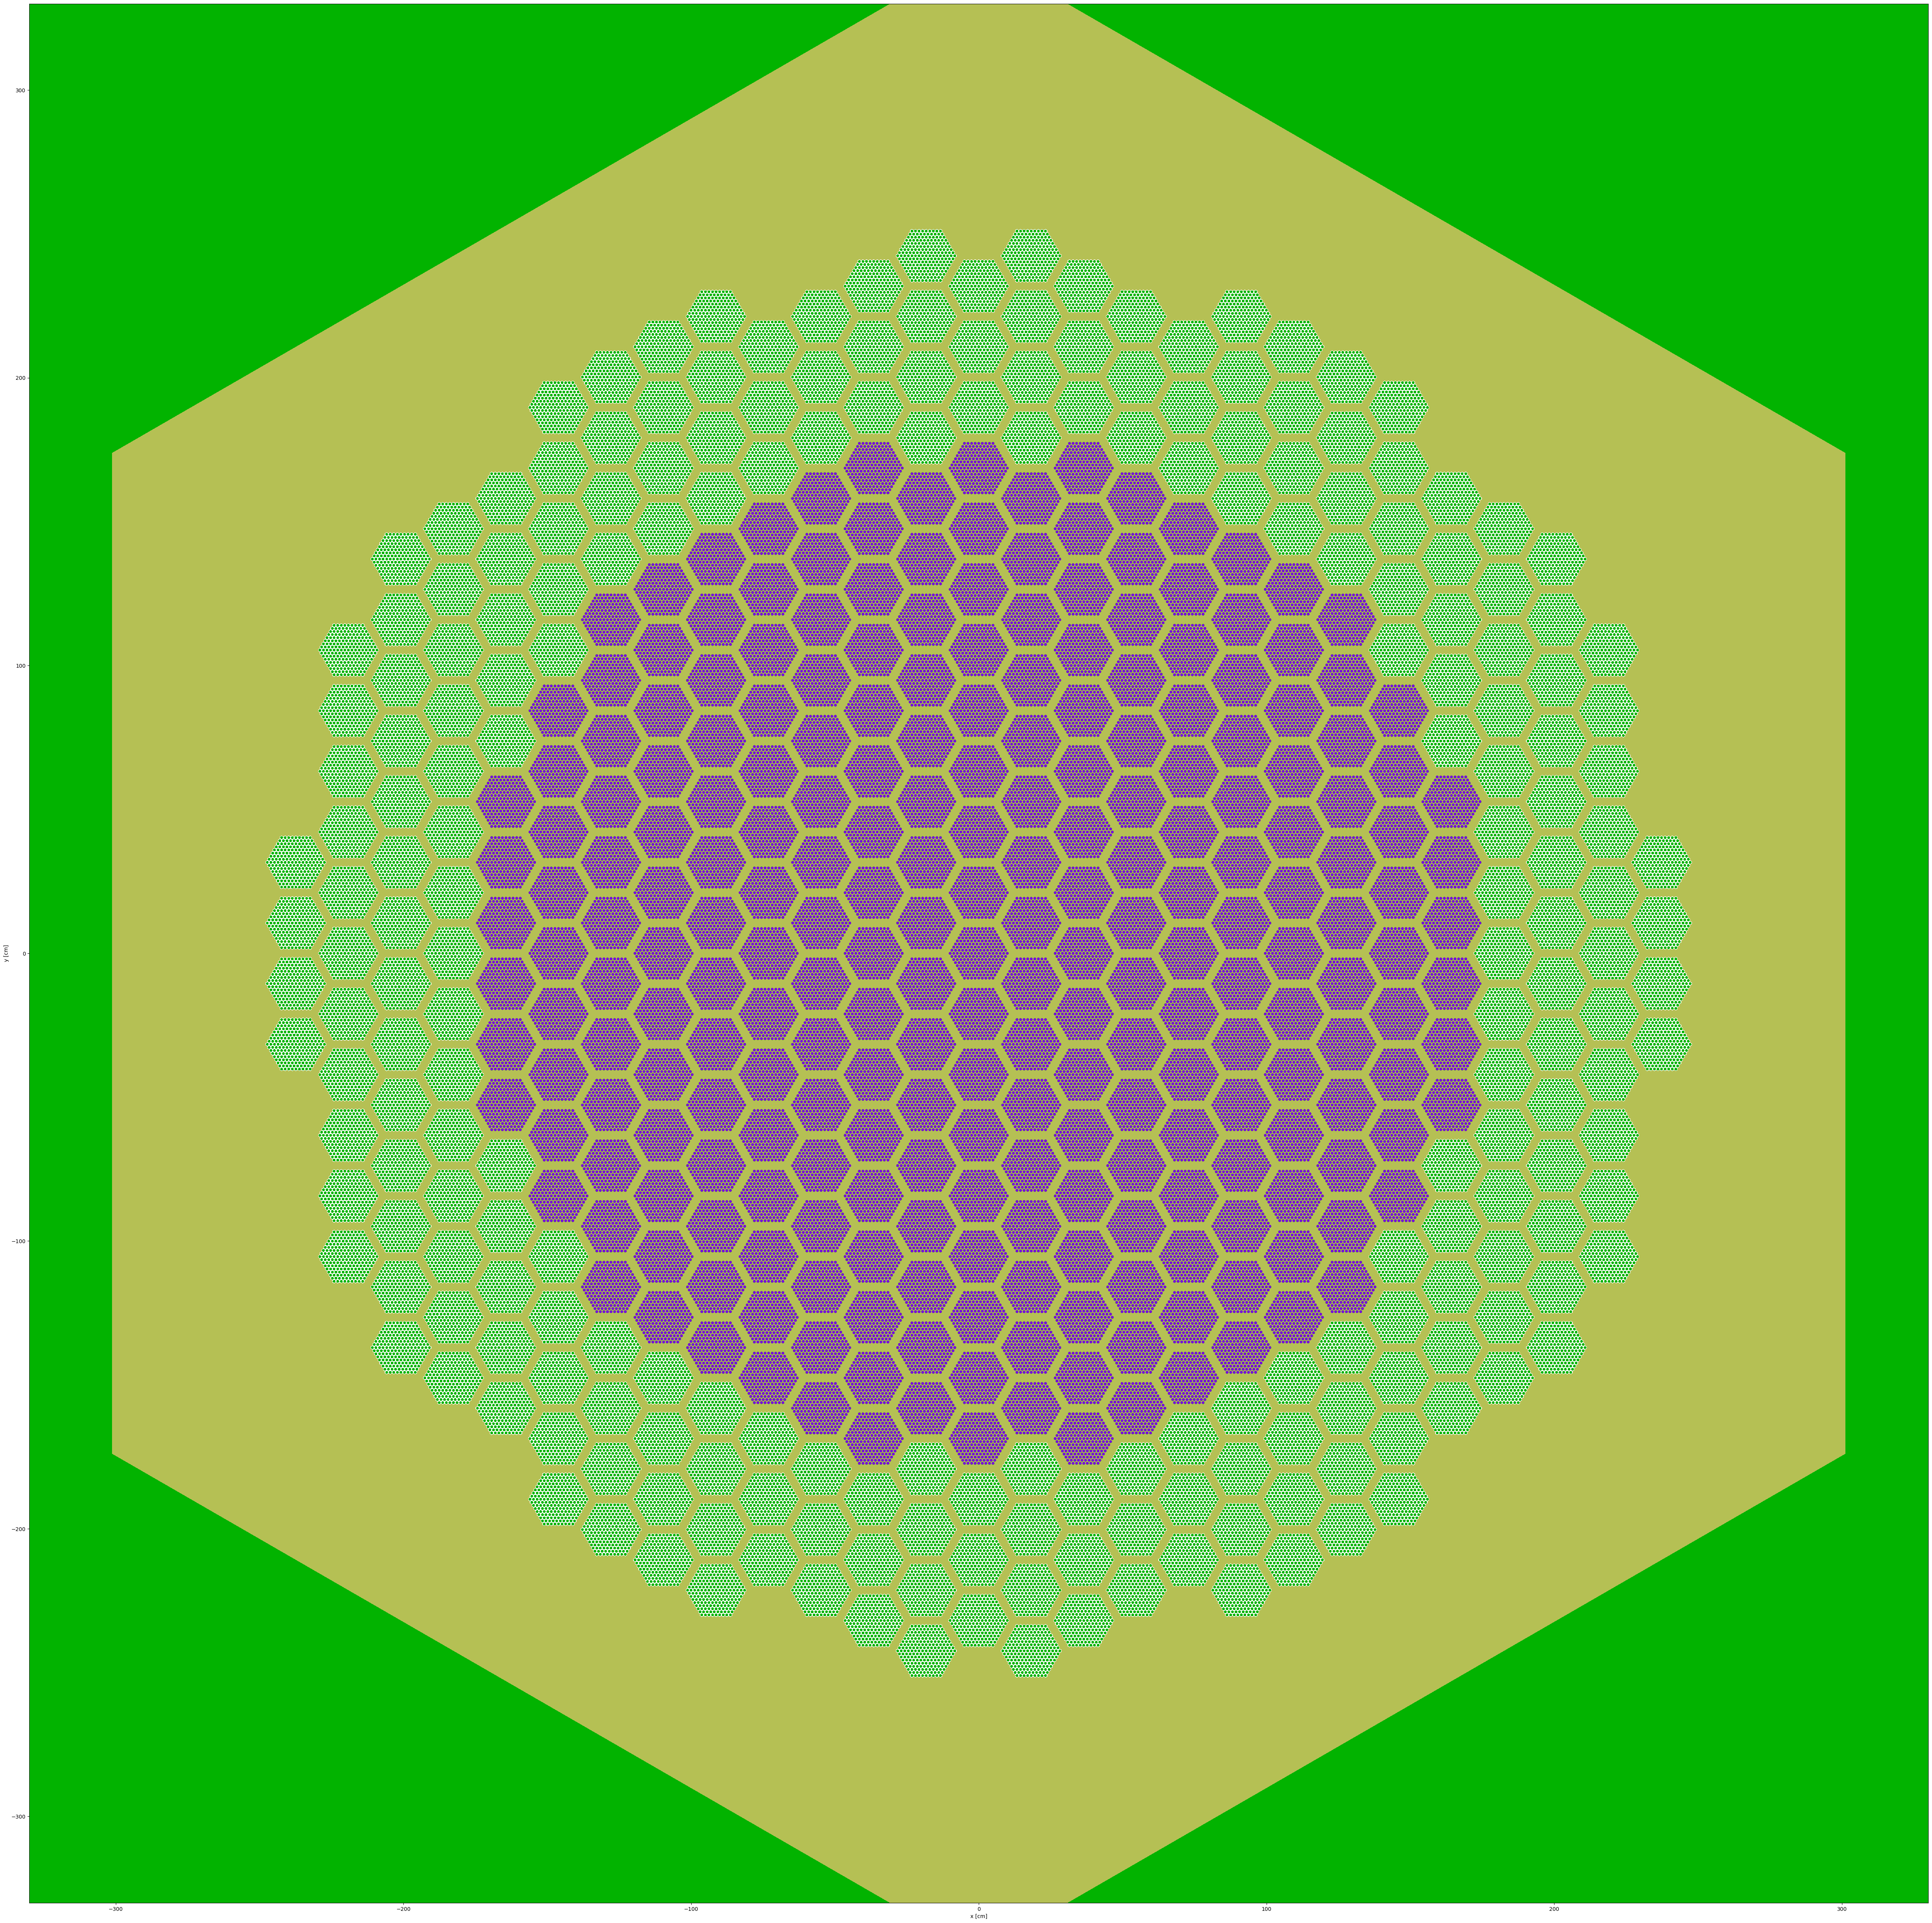

In [56]:
main_u.plot(origin = (0,0,0), pixels=(5000, 5000), width = (660.,660.), color_by = 'material')

We now have an entire reactor core defined! We can export the geometry and run the code. 

In [57]:
geom = openmc.Geometry(main_u)
geom.export_to_xml()

In [58]:
# OpenMC simulation parameters

lower_left = [-300, -300, -50]
upper_right = [300, 300, 50]
uniform_dist = openmc.stats.Box(lower_left, upper_right)
src = openmc.IndependentSource(space=uniform_dist, constraints={"fissionable": True})

settings = openmc.Settings()
settings.source = src
settings.batches = 100
settings.inactive = 10
settings.particles = 10000

settings.export_to_xml()

In [59]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

RuntimeError: Maximum number of lost particles has been reached.